## Preprocessing Koala Habitat Suitability Model 
Original model from Queensland Department of Environment and Science "Core Koala Habitat Areas Version 3"
This notebook contains preprocessing steps that were conducted for the replication, not used in the original study.

This notebook in its entirety takes approximately 5 minutes to run.
File inputs need to be changed based on user path and current working directories.

Two options for saving Plots as a PNG are given, but commented out to avoid automatic downloading. These can be uncommented to download the PNGs if desired. Otherwise, output GeoPackages are set to download in the current working directory.

   FID_L2Core      RE PERCENT_   MRE_PROPTO MME_RANK        MME_PROPTO  \
0           1  11.3.2      100  0/0/0/100/0        2   0.0/45.37/54.63   
1           2  11.3.2      100  0/0/0/100/0        3  84.12/3.91/11.97   
2           3  11.3.2      100  0/0/0/100/0        3  84.12/3.91/11.97   
3           4  11.3.2      100  0/0/0/100/0        3  84.12/3.91/11.97   
4           5  11.3.2      100  0/0/0/100/0        3  84.12/3.91/11.97   

   PT_BUFF                 HSM_VALUE HSM_CONF  HSM_CATEGO    MCOVER   AREA_HA  \
0        0  General habitat possible     High           4   Remnant  0.339582   
1        1   Preferred habitat known     High           9  Regrowth  0.463092   
2        1   Preferred habitat known     High           9  Regrowth  0.349098   
3        1   Preferred habitat known     High           9  Regrowth  0.858461   
4        1   Preferred habitat known     High           9  Regrowth  0.606985   

  MRE_RANK MRE_RANK_A HSM_RULE  Shape_Leng    Shape_Area  \
0   medi

<AxesSubplot: >

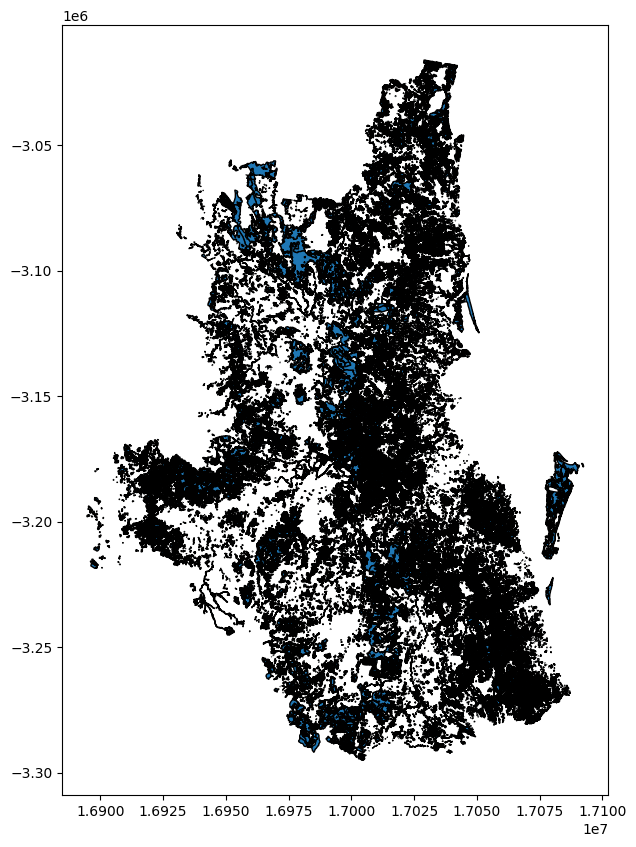

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

os.environ["SHAPE_RESTORE_SHX"] = "YES"

#Create path to shapefile from Koala Habitat Suitability Model
gdf = gpd.read_file("Data/koala habitat/koalahabitats.shp")  # CHANGE to location of "koalahabitats.shp" for user path and current working directory  

# Print basic info to check original shapefile
print(gdf.head())
print(gdf.crs)
gdf.plot(figsize=(10, 10), edgecolor="black")

Removing unnessary columns from source model

In [3]:
print("Full index:", gdf.columns)
columns_to_drop = [
    'RE',             #Regional Ecosystem (undefined region codes)
    'PERCENT_',       #RE Percent
    'MRE_PROPTO',     #Model RE proportion
    'MME_RANK',       #Model maxent rank (used for original model classification)
    'MME_PROPTO',     #Model maxent proportion
    'PT_BUFF',        #Species record buffer (binary 0 and 1, undefined)
    'HSM_CONF',       #Model confidence
    'MRE_RANK',       #Model RE suitability rank (used for original model classification)
    'MRE_RANK_A',     #Model RE suitability rank list
    'HSM_RULE'        #Habitat model decision rule
]

gdf_reduced = gdf.drop(columns=columns_to_drop)

# Check result
print("Reduced index:", gdf_reduced.columns)
print("Number of rows and columns:", gdf_reduced.shape)

Full index: Index(['FID_L2Core', 'RE', 'PERCENT_', 'MRE_PROPTO', 'MME_RANK', 'MME_PROPTO',
       'PT_BUFF', 'HSM_VALUE', 'HSM_CONF', 'HSM_CATEGO', 'MCOVER', 'AREA_HA',
       'MRE_RANK', 'MRE_RANK_A', 'HSM_RULE', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')
Reduced index: Index(['FID_L2Core', 'HSM_VALUE', 'HSM_CATEGO', 'MCOVER', 'AREA_HA',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')
Number of rows and columns: (94594, 8)


Determining smallest polygons to filter based on size

In [4]:
# Sort the 'area' column from smallest to largest
gdf_reduced['AREA_HA'].sort_values()
print(gdf_reduced['AREA_HA'].sort_values())

# Count polygons with area less than 100
count_small = (gdf_reduced['AREA_HA'] < 100).sum()
print(f"Number of polygons with area < 100: {count_small}")

# Count polygons with area less than 400 ha
count_small = (gdf_reduced['AREA_HA'] < 400).sum()
print(f"Number of polygons with area < 400: {count_small}")

print("Remove polygons with area less than 400 ha")
#Remove polygons with area < 400 ha
gdf_filtered = gdf_reduced[gdf_reduced['AREA_HA'] >= 400]
print("Number of rows and columns once filtered:", gdf_filtered.shape)

54974    1.961146e-09
35104    2.028378e-09
88549    3.511716e-09
16609    4.990920e-09
5487     5.818848e-09
             ...     
76665    3.333324e+03
27687    3.565162e+03
28123    3.588516e+03
11559    4.897464e+03
27686    6.530652e+03
Name: AREA_HA, Length: 94594, dtype: float64
Number of polygons with area < 100: 93675
Number of polygons with area < 400: 94424
Remove polygons with area less than 400 ha
Number of rows and columns once filtered: (170, 8)


Analyzing Model's High and Low Suitability Categories:

Category counts:
4     12
5     11
6     87
7      4
8     13
9     39
10     4
Name: HSM_CATEGO, dtype: int64


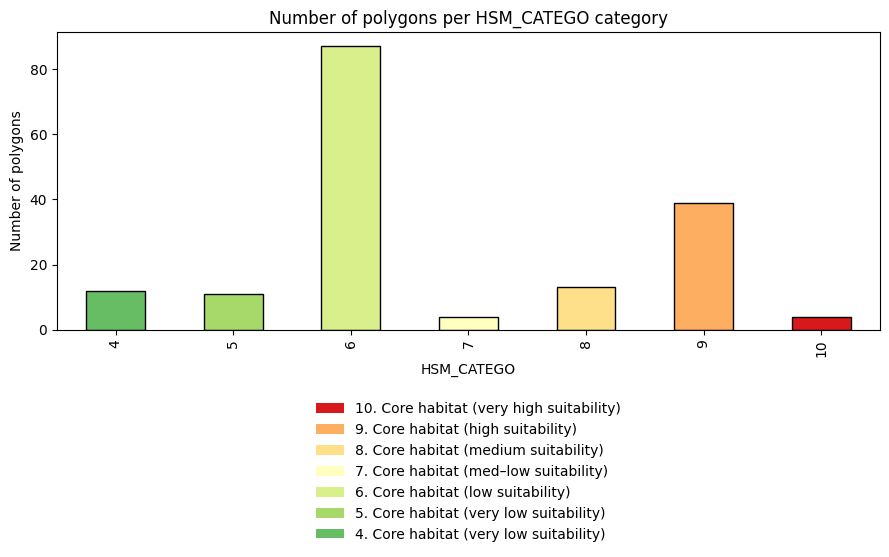

In [5]:
#count the number of polygons within each suitability category
category_counts = (
    gdf_filtered[gdf_filtered["HSM_CATEGO"].between(4, 10)]
    ["HSM_CATEGO"]
    .value_counts()
    .sort_index()
    .reindex(range(4, 11), fill_value=0)
)

# Colour + label based on Queensland model classification
category_info = {
    10: ("#d7191c", "Core habitat (very high suitability)"),
    9:  ("#fdae61", "Core habitat (high suitability)"),
    8:  ("#fee08b", "Core habitat (medium suitability)"),
    7:  ("#ffffbf", "Core habitat (med–low suitability)"),
    6:  ("#d9ef8b", "Core habitat (low suitability)"),
    5:  ("#a6d96a", "Core habitat (very low suitability)"),
    4:  ("#66bd63", "Core habitat (very low suitability)")
}
print("Category counts:")
print(category_counts)

#show results as barchart
fig, ax = plt.subplots(figsize=(9, 6))

bar_colors = [category_info[c][0] for c in category_counts.index]

category_counts.plot(
    kind="bar",
    ax=ax,
    color=bar_colors,
    edgecolor="black"
)

ax.set_xlabel("HSM_CATEGO")
ax.set_ylabel("Number of polygons")
ax.set_title("Number of polygons per HSM_CATEGO category")

legend_handles = [
    Patch(facecolor=category_info[c][0], label=f"{c}. {category_info[c][1]}")
    for c in sorted(category_info.keys(), reverse=True)
]

ax.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    frameon=False
)

plt.tight_layout()
plt.show()


Correcting any invalid geometries before saving:

In [6]:
#check invalid geometries in gdf_filtered
invalid = gdf_filtered[~gdf_filtered.is_valid]
print(f"Number of invalid geometries before fixing: {len(invalid)}")

#fix invalid geometries
from shapely.validation import make_valid

gdf_filtered['geometry'] = gdf_filtered['geometry'].apply(make_valid)

#check to confirm fix
invalid = gdf_filtered[~gdf_filtered.is_valid]
print(f"Number of invalid geometries after fixing: {len(invalid)}")

Number of invalid geometries before fixing: 8
Number of invalid geometries after fixing: 0


/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# Save the preprocessed modal to a GeoPackage
gdf_filtered.to_file("Outputs/Preprocessed_Koala_Habitat.gpkg", layer="high_polygons", driver="GPKG")

Output of Preprocessing: Saved gpkg with valid, high suitability polygons with area > 400 ha

# Comparing Koala Habitat to Replication Study Area

<bound method NDFrame.head of      Shape_Leng    Shape_Area  \
0  2.007465e+06  3.422137e+10   

                                            geometry  
0  MULTIPOLYGON (((17077775.385 -3240312.863, 170...  >


<AxesSubplot: >

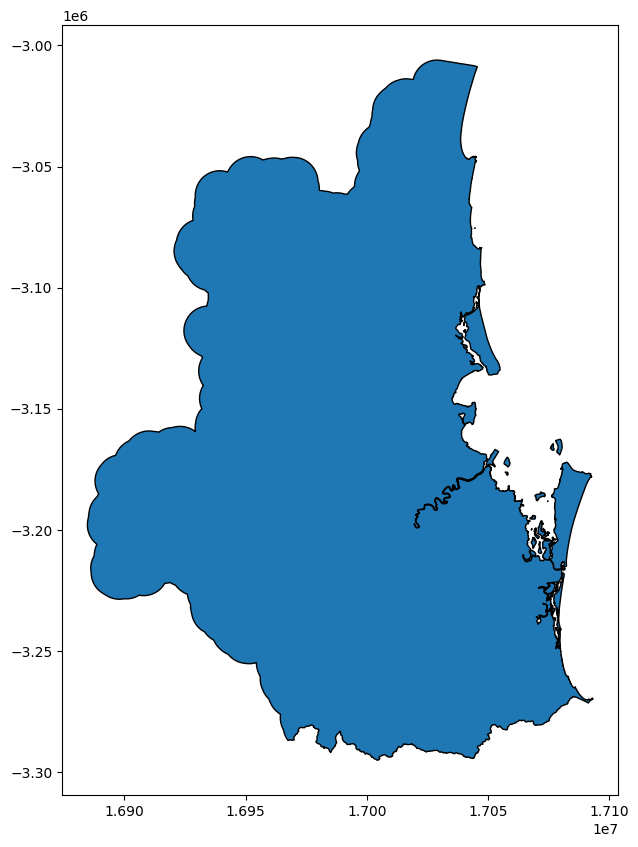

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from shapely.ops import unary_union
os.environ["SHAPE_RESTORE_SHX"] = "YES"

#Link Preprocessed_Koala_Habitat.gpkg to avoid preprocessing steps each time
Koala_hab = gpd.read_file("Data/koala habitat/koalahabitats.shp") # CHANGE to location user path and current working directory
#uploading and visualizing Study Area (extent of Koala Habitat Suitability Model)
study = gpd.read_file("Data/study_area.gpkg")                     # CHANGE to location user path and current working directory
print(study.head)
study.plot(figsize=(10, 10), edgecolor="black")

Aligning Koala Habitat polygons to study area:

In [ ]:
# Ensure same CRS
Koala_hab = Koala_hab.to_crs(study.crs)

# Fix invalid geometries
Koala_hab['geometry'] = Koala_hab['geometry'].buffer(0)

# Clip polygons
Koala_clip = gpd.clip(Koala_hab, study)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
Koala_clip.plot(ax=ax, edgecolor="black")
ax.set_title("High Suitability Habitat in Study Area, >400 ha", fontsize=16)
plt.show()


# Assigning Suitability Categories
Assign suitability categories based on HSM_CATEGO values
Values 4-6 assigned suitability 1 (low), Values 7-10 assigned suitability 2 (High)
The rest of the study area is considered non-habitat and assigned suitability 0

In [ ]:
#Assigning low and high suitability
conditions = [
    Koala_clip["HSM_CATEGO"].between(4, 6),
    Koala_clip["HSM_CATEGO"].between(7, 10)
]
choices = [1, 2]

Koala_clip["suitability"] = np.select(conditions, choices, default=0)

#Assigning non-habitat
study_low = []

for idx, study_poly in study.iterrows():
    # Find overlapping high suitability polygons
    overlap = Koala_clip[Koala_clip.geometry.intersects(study_poly.geometry)]
    
    # Start with the original study polygon
    geom = study_poly.geometry
    
    # Subtract each overlapping high suitability polygon one by one
    for _, high_poly in overlap.iterrows():
        geom = geom.difference(high_poly.geometry)
    
    if not geom.is_empty:
        study_low.append({
            'geometry': geom,
            'suitability': 0,
            **{col: study_poly[col] for col in study.columns if col != 'geometry'}
        })

study_low = gpd.GeoDataFrame(study_low, crs=study.crs)

# Combining high and low suitability polygons
suitability_map = gpd.GeoDataFrame(
    pd.concat([Koala_clip, study_low], ignore_index=True),
    crs=study.crs
)

# Category Value Check
print("Check Category Values:")
print(suitability_map["suitability"].value_counts())


#Plotting final Koala Habitat Suitability Map for the study area
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colors: 0 = light blue, 1 = yellow, 2 = dark green
cmap = ListedColormap(["#ADD8E6", "#FFFF00", "#006400"])  

fig, ax = plt.subplots(figsize=(10, 10))
suitability_map.plot(
    ax=ax,
    column="suitability",
    cmap=cmap,
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    categorical=True
)

ax.set_title("Koala Habitat Suitability Map (2 = High, 1 = Low, 0 = NonHabitat)", fontsize=16)
plt.show()

#can save plot as PNG
#plt.savefig("study_suitability_map.png", dpi=300, bbox_inches='tight')

Exporting options

In [ ]:
#saving to GeoPackage
suitability_map.to_file(
    "Outputs/study_suitability_map.gpkg", 
    layer="suitability", 
    driver="GPKG"
)

In [ ]:
#saving to TIFF
import rasterio
from rasterio.features import rasterize

# Get bounds and resolution
bounds = suitability_map.total_bounds  # xmin, ymin, xmax, ymax
resolution = 100  # size of each pixel in CRS units (e.g., meters)

# Define raster dimensions
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)

# Transform
from rasterio.transform import from_bounds
transform = from_bounds(*bounds, width=width, height=height)

# Rasterize: assign polygon 'suitability' values to pixels
raster = rasterize(
    [(geom, value) for geom, value in zip(suitability_map.geometry, suitability_map.suitability)],
    out_shape=(height, width),
    transform=transform,
    fill=0,  # background value
    dtype='uint8'
)

# Save as TIFF
with rasterio.open(
    "Outputs/study_suitability_map.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=suitability_map.crs,
    transform=transform
) as dst:
    dst.write(raster, 1)
